In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset

In [12]:
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('Datasets/marketing_sales_data.csv')
df = data.dropna()
df = df[['Radio', 'Sales']]
# Initialize MinMaxScaler
scaler = StandardScaler()

# Apply normalization
df = scaler.fit_transform(df)

df = pd.DataFrame(df, columns=['Radio', 'Sales'])
df['Radio'] = df['Radio'] *2
# df['Sales'] = df['Sales'] *7

df.head()

,Radio,Sales
0,-3.615561,-1.145752
1,-0.757303,0.324483
2,-1.709096,-1.004803
3,1.640526,1.493444
4,3.806794,1.754587


# Model

In [14]:
def linear_function(x, w):
    """Calculate y_hat using a linear function."""
    t = np.dot(x, w)
    y_hat = t
    return y_hat

def calculate_loss(y, y_hat):
    """Calculate loss function."""
    cost = (y - y_hat)**2
    loss = np.mean(cost, axis = 0)
    return loss

def calculate_gradient(X, y, y_hat):
    """Calculate gradients."""
    dLdw = -2 * np.dot(X.T, (y - y_hat)) / y.shape[0]
    return dLdw

In [15]:
w0_range = np.linspace(-6, 6, 100)
w1_range = np.linspace(-6, 6, 100)
w0_mesh, w1_mesh = np.meshgrid(w0_range, w1_range)

X = df['Radio'].values
X = np.c_[np.ones(X.shape[0]), X]
y = df['Sales'].values

Text(0.5, 0.92, 'Loss Surface with Contour Labels')

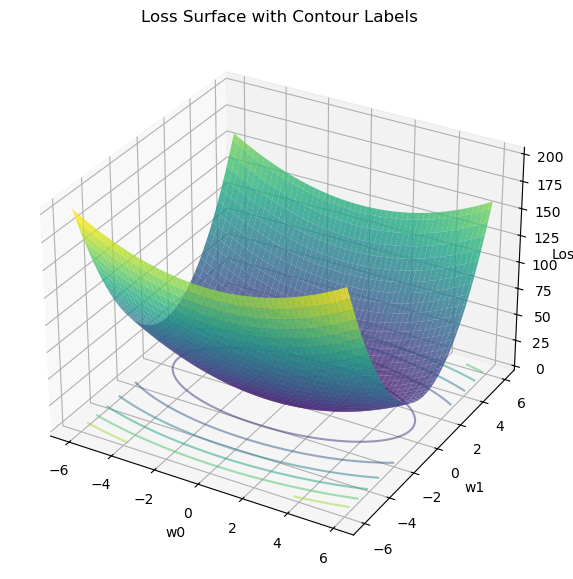

In [5]:
w0_w1 = np.array([w0_mesh.ravel(), w1_mesh.ravel()])
y_hat = linear_function(X, w0_w1)
loss = calculate_loss(y.reshape(-1, 1), y_hat)
loss_mesh = loss.reshape(w0_mesh.shape)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(18, 7))

# Plot the surface
ax.plot_surface(w0_mesh, w1_mesh, loss_mesh, cmap='viridis', alpha=0.8)

# Create 2D contour plot
contour = ax.contour(w0_mesh, w1_mesh, loss_mesh, zdir='z', offset=0, cmap='viridis', alpha=0.5)

# Set labels for all axes
ax.set_xlabel('w0')
ax.set_ylabel('w1')
ax.set_zlabel('Loss', labelpad=0.02)
ax.set_title('Loss Surface with Contour Labels')

In [6]:
X = df['Radio'].values
X = np.c_[np.ones(X.shape[0]), X]
y = df['Sales'].values

In [127]:
epochs = 200
alpha = 0.2
beta_average = 0.9
beta_step = 0.7
batch_size = 100
epsilon = 10e-8
w = np.random.uniform(4, 6, size=(2,))
w

array([5.08477999, 4.72742291])

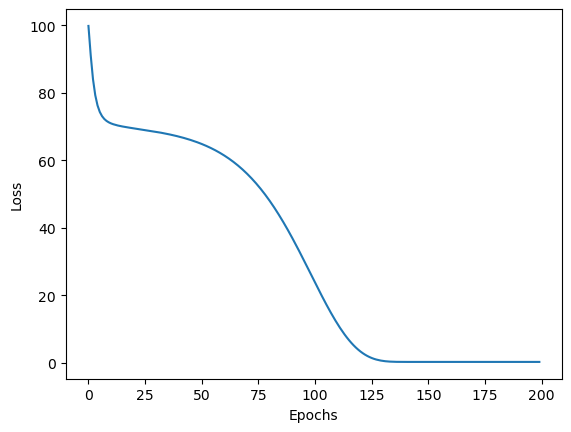

In [128]:
# Trainning (mini-batch)
from sklearn.metrics import f1_score, accuracy_score
def GD_mini_batch(X_train, y_train, w, alpha, epochs):
    lossess = np.array([])
    w_collect = w.reshape(1, -1)

    for epoch in range(epochs):
        # Training loop

        #Calculate z
        y_hat = linear_function(X_train, w)

        #Calculate loss
        loss = calculate_loss(y_train, y_hat)
        lossess = np.append(lossess, loss)
        
        #Calculate gradient
        dldw = calculate_gradient(X_train, y_train, y_hat)

        # Update w (SGD_momentum)
        if epoch == 0:
            momentum = np.zeros_like(w)
            average = np.zeros_like(w)


        step = beta_step * momentum + (1 - beta_step) * dldw

        average = beta_average * average + (1 - beta_average) * np.square(dldw)

        step = step / (1 - beta_step**(epoch + 1)) # step corrected

        average = average / (1 - beta_average**(epoch + 1)) # average corrected
        
        w = w - alpha / ((np.sqrt(average) + epsilon)) * step
        
        # Collecting dldw, momentum, step
        if epoch == 0:
            dldw_collect = dldw.reshape(1, -1)
            momentum_collect = momentum.reshape(1, -1)
            step_collect = step.reshape(1, -1)
        else:
            dldw_collect = np.vstack((dldw_collect, dldw.reshape(1, -1)))
            momentum_collect = np.vstack((momentum_collect, momentum.reshape(1, -1)))
            step_collect = np.vstack((step_collect, step.reshape(1, -1)))

        # Collecting w
        if epoch != epochs - 1:
            w_collect = np.vstack((w_collect, w.reshape(1, -1)))
        
        momentum = step

    return lossess, dldw_collect, w_collect, momentum_collect, step_collect

lossess, dldw_collect, w_collect, momentum_collect, step_collect = GD_mini_batch(X, y, w, alpha, epochs)
plt.plot(lossess)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


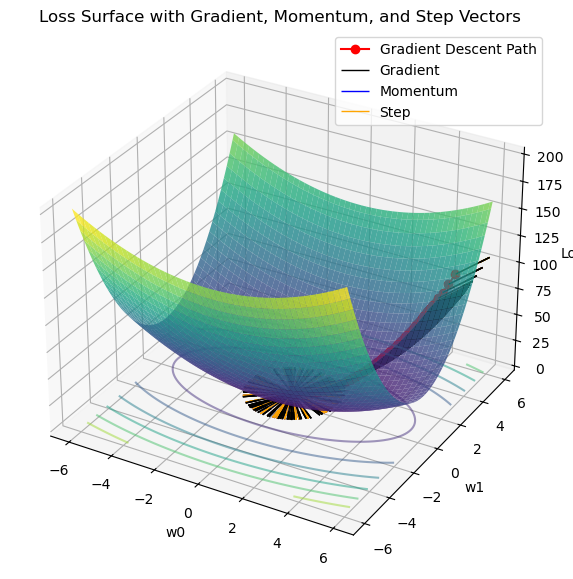

In [129]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(18, 7))

# Plot the surface
ax.plot_surface(w0_mesh, w1_mesh, loss_mesh, cmap='viridis', alpha=0.8)

# Create 2D contour plot
ax.contour(w0_mesh, w1_mesh, loss_mesh, zdir='z', offset=0, cmap='viridis', alpha=0.5)

# Plot the gradient descent path
ax.plot(w_collect[:, 0], w_collect[:, 1], lossess, color='red', marker='o', label='Gradient Descent Path')

# Normalize vectors for visualization
def normalize(vectors, scale=0.5, eps=1e-8):
    norm = np.linalg.norm(vectors, axis=1, keepdims=True)
    return scale * vectors / (norm + eps)

# Gradients
gradients = normalize(dldw_collect)
ax.quiver(
    w_collect[:, 0], w_collect[:, 1], lossess,
    gradients[:, 0], gradients[:, 1], np.zeros_like(gradients[:, 0]),
    color='black', length=4, linewidth=1, arrow_length_ratio=0.3,
    label='Gradient'
)

# Momentum vectors
momentum_norm = normalize(momentum_collect)
ax.quiver(
    w_collect[:, 0], w_collect[:, 1], lossess,
    momentum_norm[:, 0], momentum_norm[:, 1], np.zeros_like(momentum_norm[:, 0]),
    color='blue', length=4, linewidth=1, arrow_length_ratio=0.3,
    label='Momentum'
)

# Step vectors
step_norm = normalize(step_collect)
ax.quiver(
    w_collect[:, 0], w_collect[:, 1], lossess,
    step_norm[:, 0], step_norm[:, 1], np.zeros_like(step_norm[:, 0]),
    color='orange', length=4, linewidth=1, arrow_length_ratio=0.3,
    label='Step'
)

# Labels and legend
ax.set_xlabel('w0')
ax.set_ylabel('w1')
ax.set_zlabel('Loss')
ax.set_title('Loss Surface with Gradient, Momentum, and Step Vectors')
ax.legend()

plt.show()


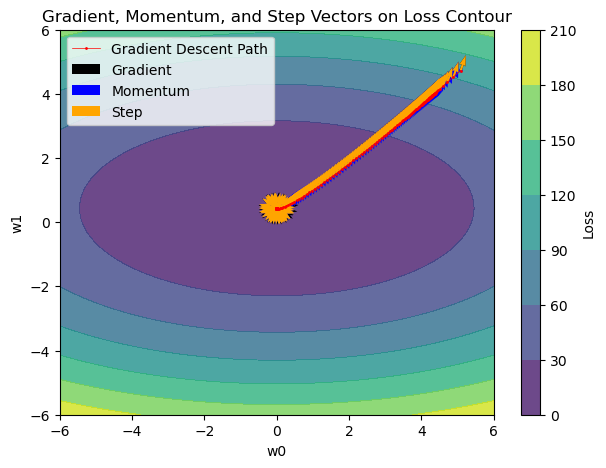

In [130]:
import numpy as np
import matplotlib.pyplot as plt

# Create the contour plot for the loss surface
plt.figure(figsize=(7, 5))
contour = plt.contourf(w0_mesh, w1_mesh, loss_mesh, cmap='viridis', alpha=0.8)
plt.colorbar(label="Loss")

# Plot the gradient descent path
plt.plot(w_collect[:, 0], w_collect[:, 1], color='red', marker='o',markersize=1, linewidth=0.5, linestyle='-', label="Gradient Descent Path")

# Normalize vectors for visualization
def normalize(vectors, scale=0.5, eps=1e-8):
    norm = np.linalg.norm(vectors, axis=1, keepdims=True)
    return scale * vectors / (norm + eps)

# Gradients, momentum, and steps
gradients = normalize(dldw_collect)
momentum_vecs = normalize(momentum_collect)
step_vecs = normalize(step_collect)


# Plot gradient vectors (black)
plt.quiver(
    w_collect[:-1, 0], w_collect[:-1, 1],
    gradients[:-1, 0], gradients[:-1, 1],
    color='black', angles='xy', scale_units='xy', scale=1, width=0.005, label='Gradient'
)

# Plot momentum vectors (blue)
plt.quiver(
    w_collect[:-1, 0], w_collect[:-1, 1],
    momentum_vecs[:-1, 0], momentum_vecs[:-1, 1],
    color='blue', angles='xy', scale_units='xy', scale=1, width=0.01, label='Momentum'
)

# Plot step vectors (orange)
plt.quiver(
    w_collect[:-1, 0], w_collect[:-1, 1],
    step_vecs[:-1, 0], step_vecs[:-1, 1],
    color='orange', angles='xy', scale_units='xy', scale=1, width=0.005, label='Step'
)

# Labels and title
plt.xlabel("w0")
plt.ylabel("w1")
plt.title("Gradient, Momentum, and Step Vectors on Loss Contour")
plt.legend()
plt.show()
